# Starter Notebook

Install and import required libraries

In [1]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3
!pip install tensorboard
!pip install ipywidgets --user

# !pip uninstall keras tensorflow tensorflow-io --yes

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import pandas as pd
import torch
import evaluate # Use evaluate library for metrics
from transformers import (
    RobertaForSequenceClassification,
    RobertaTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback # Import EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm.notebook import tqdm # Use notebook version of tqdm if in Colab/Jupyter
from torch.utils.data import DataLoader
import pickle # Keep pickle for loading the test set

2025-04-20 17:36:27.195827: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-20 17:36:28.742650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745184989.283837    5784 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745184989.428117    5784 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745184990.769102    5784 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Load Tokenizer and Preprocess Data

In [3]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

In [4]:
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
id2label = {i: label for i, label in enumerate(class_names)}
label2id = {label: i for i, label in enumerate(class_names)} # Useful for model config
print(f"Number of labels: {num_labels}")
print(f"Labels: {class_names}")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

Number of labels: 4
Labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [5]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    num_labels=num_labels, # Pass num_labels
    id2label=id2label,    # Pass mappings
    label2id=label2id
)
model

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Anything from here on can be modified

In [6]:
split_datasets = tokenized_dataset.train_test_split(test_size=0.10, seed=42, stratify_by_column='labels') # Stratify is good practice
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']
print(f"Train dataset size: {len(train_dataset)}")
print(f"Eval dataset size: {len(eval_dataset)}")

Train dataset size: 108000
Eval dataset size: 12000


## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [7]:
peft_config = LoraConfig(
    r=12,  
    lora_alpha=48,  
    lora_dropout=0.1,  
    bias="none",
    target_modules=["query", "value", "roberta.encoder.layer.*.output.dense"],
    layers_to_transform=list(range(8, 12)),  
    rank_pattern={
        "8": 16,  
        "9": 24,
        "10": 32,
        "11": 32
    },
    task_type="SEQ_CLS"
)

#### LoRA configuration

- `r=12`  
  size of the low‑rank decomposition  
- `lora_alpha=48`  
  scaling factor applied to the LoRA updates  
- `lora_dropout=0.1`  
  dropout rate for LoRA layers (adds regularization)  
- `bias="none"`  
  Do not apply LoRA adapters to bias terms  
- `target_modules`  
  list of submodules to modify:  
  - `"query"` and `"value"` attention projections  
  - the output dense layer in each Roberta encoder block  
- `layers_to_transform=list(range(8,12))`  
  only inject LoRA into encoder layers 8, 9, 10, and 11  
- `rank_pattern`  
  custom low‑rank sizes per layer:  
  - layer 8 → rank 16  
  - layer 9 → rank 24  
  - layer 10 → rank 32  
  - layer 11 → rank 32  
- `task_type="SEQ_CLS"`  
  indicates a sequence classification task  


In [8]:
peft_model = get_peft_model(model, peft_config)
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-7): 8 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False

In [9]:
print("--- PEFT Model Configured ---")
peft_model.print_trainable_parameters() # Check the number of trainable parameters!

--- PEFT Model Configured ---
trainable params: 741,124 || all params: 125,389,832 || trainable%: 0.5911


## Training Setup

In [10]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

#### compute_metrics

- takes in the model’s raw outputs and the true labels  
- finds the predicted class for each example (highest score)  
- computes overall accuracy  
- computes weighted precision, recall and F1‑score across all classes  
- returns a dictionary with these four metrics  


In [14]:
output_dir = "results_iter1"
logging_dir = f"{output_dir}/logs" 

training_args = TrainingArguments(
    output_dir=output_dir,
    
    # --- Training Strategy ---
    num_train_epochs=10,             # Training for 10 full epochs
    per_device_train_batch_size=16, 
    gradient_accumulation_steps=1,  
    
    # --- Optimizer & Scheduler ---
    optim="adamw_torch",            # AdamW optimizer
    learning_rate=2e-5,             
    lr_scheduler_type='linear',     # Using learning rate decay
    warmup_ratio=0.05,              
    weight_decay=0.01,              
    
    # --- Evaluation Strategy ---
    evaluation_strategy="epoch",    
    per_device_eval_batch_size=64,  
    
    # --- Saving Strategy ---
    save_strategy="epoch",          
    save_total_limit=1,             # Only keep the best checkpoint
    load_best_model_at_end=True,    
    metric_for_best_model="accuracy",
    greater_is_better=True,         
    
    # --- Logging ---
    logging_dir=logging_dir,        
    logging_strategy="epoch",       
    report_to="tensorboard",        
    
    # --- Other ---
    seed=69,                        
    fp16=torch.cuda.is_available(), 
    dataloader_num_workers=4,       
)

trainer = Trainer(
    model=peft_model,               
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,            
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] 
)


/home/pp3051/.local/lib/python3.9/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_5784/609724972.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


#### training setup

- defines where to save outputs (`results_iter1`) and logs  
- runs for 7 epochs with batch size 16 and no gradient accumulation  
- uses AdamW optimizer with a 2 × 10⁻⁵ learning rate, linear decay, 5% warmup, and 0.01 weight decay  

#### evaluation & saving

- evaluates on the validation set at the end of every epoch (batch size 64)  
- saves one checkpoint per epoch and keeps only the best (by accuracy)  
- automatically loads the best model when training finishes  

#### logging & misc

- writes TensorBoard logs each epoch in `results_iter1/logs`  
- sets a fixed random seed (69) and uses mixed precision if a GPU is available  
- uses 4 data‑loading workers for speed  

#### trainer initialization

- creates a `Trainer` with your PEFT‑wrapped model  
- supplies the train and eval datasets, tokenizer, and data collator  
- hooks up `compute_metrics` for automated metric reporting  
- adds an early‑stopping callback (stop after 3 bad epochs)  


### Start Training

In [15]:
print("--- Starting Training ---")
train_result = trainer.train()

--- Starting Training ---


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.227300,0.231057,0.926500,0.926732,0.927734,0.926500
2,0.221100,0.215681,0.929750,0.929835,0.930413,0.929750
3,0.214200,0.209699,0.929500,0.929350,0.929403,0.929500
4,0.208900,0.206132,0.933250,0.933203,0.933300,0.933250
5,0.205400,0.203440,0.934417,0.934456,0.934857,0.934417
6,0.200400,0.204865,0.934833,0.934874,0.935139,0.934833
7,0.198200,0.202023,0.935250,0.935267,0.935358,0.935250
8,0.196800,0.204597,0.935250,0.935261,0.935824,0.935250
9,0.195000,0.204761,0.935500,0.935473,0.936043,0.935500
10,0.193900,0.202938,0.935250,0.935248,0.935660,0.935250


## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

### Run Inference on eval_dataset

In [16]:
print("--- Evaluating Best Model on Validation Set ---")
eval_metrics = trainer.evaluate(eval_dataset=eval_dataset)
trainer.log_metrics("eval", eval_metrics)
print(f"Evaluation Metrics: {eval_metrics}")

--- Evaluating Best Model on Validation Set ---


***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.9355
  eval_f1                 =     0.9355
  eval_loss               =     0.2048
  eval_precision          =      0.936
  eval_recall             =     0.9355
  eval_runtime            = 0:00:08.22
  eval_samples_per_second =   1459.158
  eval_steps_per_second   =      22.86
Evaluation Metrics: {'eval_loss': 0.2047613561153412, 'eval_accuracy': 0.9355, 'eval_f1': 0.9354727551356247, 'eval_precision': 0.9360427505756429, 'eval_recall': 0.9355, 'eval_runtime': 8.2239, 'eval_samples_per_second': 1459.158, 'eval_steps_per_second': 22.86, 'epoch': 10.0}


--- Plotting Training Metrics ---
Metrics plot saved to results_iter1/training_metrics.png


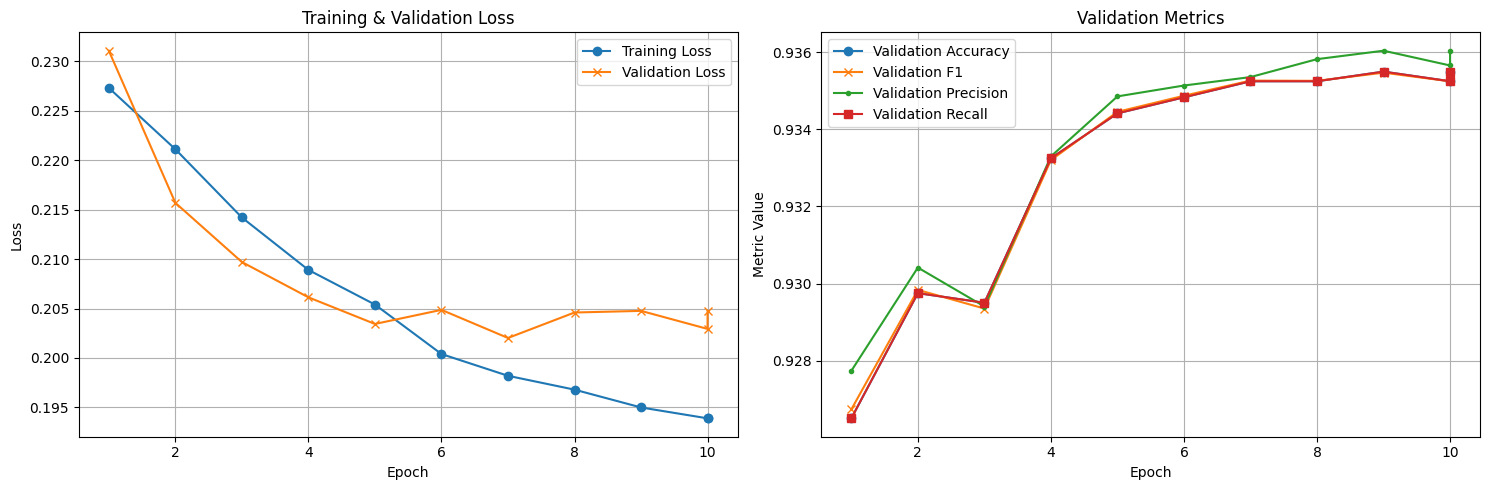

In [17]:
import matplotlib.pyplot as plt
def plot_metrics(log_history):
    """Plots training/validation loss and validation metrics from training logs."""
    print("--- Plotting Training Metrics ---")
    epochs = []
    train_losses = []
    eval_losses = []
    eval_accuracies = []
    eval_f1s = []
    eval_precisions = []
    eval_recalls = []

    for log in log_history:
        if 'eval_loss' in log: # Look for evaluation logs
            epochs.append(log['epoch'])
            eval_losses.append(log['eval_loss'])
            eval_accuracies.append(log['eval_accuracy'])
            eval_f1s.append(log['eval_f1'])
            eval_precisions.append(log['eval_precision'])
            eval_recalls.append(log['eval_recall'])
            if 'loss' in log:
                train_losses.append(log['loss'])
            else:
                train_loss_found = False
                for prev_log in reversed(log_history[:log_history.index(log)]):
                     if 'loss' in prev_log and 'eval_loss' not in prev_log:
                          train_losses.append(prev_log['loss'])
                          train_loss_found = True
                          break
                if not train_loss_found:
                     train_losses.append(None) 


    if len(train_losses) > len(epochs):
        train_losses = train_losses[-len(epochs):] 
    elif len(train_losses) < len(epochs) and None in train_losses:
         print("Warning: Could not align all training losses with evaluation epochs.")
         train_losses = [tl if tl is not None else (eval_losses[i] if eval_losses else 0) for i, tl in enumerate(train_losses)]


    if not epochs:
        print("No evaluation logs found in history. Cannot plot metrics.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(epochs, train_losses, label='Training Loss', marker='o')
    axes[0].plot(epochs, eval_losses, label='Validation Loss', marker='x')
    axes[0].set_title('Training & Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(epochs, eval_accuracies, label='Validation Accuracy', marker='o')
    axes[1].plot(epochs, eval_f1s, label='Validation F1', marker='x')
    axes[1].plot(epochs, eval_precisions, label='Validation Precision', marker='.')
    axes[1].plot(epochs, eval_recalls, label='Validation Recall', marker='s')
    axes[1].set_title('Validation Metrics')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Metric Value')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout() 

    output_dir = training_args.output_dir # Get output dir from TrainingArguments
    plot_filename = os.path.join(output_dir, "training_metrics.png")
    plt.savefig(plot_filename)
    print(f"Metrics plot saved to {plot_filename}")

    plt.show() 

plot_metrics(trainer.state.log_history)


### Run Inference on unlabelled dataset

In [18]:
from tqdm import tqdm  

def predict_on_test_dataset(model, tokenizer, test_dataset_path="test_unlabelled.pkl", batch_size=32):
    """Run inference on the test dataset and save predictions to CSV"""
    print(f"Loading test dataset from: {test_dataset_path}")
    
    # Load the test dataset
    with open(test_dataset_path, 'rb') as f:
        test_dataset = pickle.load(f)
    
    print(f"Test dataset loaded successfully. Type: {type(test_dataset)}")
    print(f"Dataset features: {test_dataset.column_names}")
    print(f"Number of examples: {len(test_dataset)}")
    
    print("Preprocessing test data...")
    # Tokenize the text data
    def preprocess(examples):
        return tokenizer(examples['text'], truncation=True, padding=True)
    
    test_tokenized = test_dataset.map(preprocess, batched=True, remove_columns=['text'])
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    # Creating data loader for batched inference
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
    test_dataloader = DataLoader(test_tokenized, batch_size=batch_size, collate_fn=data_collator)
    
    all_predictions = []
    print(f"Running inference on {len(test_dataset)} examples...")
    
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Inference"):
            batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
            outputs = model(**batch)
            predictions = outputs.logits.argmax(dim=-1)
            all_predictions.append(predictions.cpu().numpy())
    
    # Concatenate predictions from all batches
    all_predictions = np.concatenate(all_predictions)
    print(f"Inference completed. Generated {len(all_predictions)} predictions.")

    output_df = pd.DataFrame({'ID': range(len(all_predictions)), 'Label': all_predictions})
    
    output_dir = "results"
    os.makedirs(output_dir, exist_ok=True)
    submission_filename = os.path.join(output_dir, "inference_output.csv")
    output_df.to_csv(submission_filename, index=False)
    print(f"Predictions saved to {submission_filename}")
    
    return all_predictions


predictions = predict_on_test_dataset(peft_model, tokenizer)


Loading test dataset from: test_unlabelled.pkl
Test dataset loaded successfully. Type: <class 'datasets.arrow_dataset.Dataset'>
Dataset features: ['text']
Number of examples: 8000
Preprocessing test data...


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Running inference on 8000 examples...


Inference: 100%|██████████| 250/250 [00:06<00:00, 38.55it/s]


Inference completed. Generated 8000 predictions.
Predictions saved to results/inference_output.csv
